In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("projA2.ipynb")

# Project A2: Predicting Housing Prices in Cook County

## Due Date: Monday, July 24th, 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Monday, July 24th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *Andres Larios*



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

## Introduction

In project A1, you performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this project, you will specify and fit a linear model to a few features of the housing data to predict house prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`.
- Using `scikit-learn` to build and fit linear models.

## Score Breakdown

Question | Manual | Points
----|----|----
00 | No| 2
0a | Yes | 1
0b | Yes | 1
0c | No | 1
0d | Yes | 1
0e | Yes | 1
1 | No | 2
2a | Yes | 2
2b | No | 3
2c | No | 2
3a | Yes | 2
3b | No | 1
4a | No | 0
4b | No | 0
4c | No | 0
4d | No | 0
4e | No | 3
Test Prediction | No | 3
4f | No | 0
4g | No | 0
4h | No | 0
5a | No | 0
5b | No | 0
5c | No | 0
Total | 6 | 26


In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training/validation and test data.

In [3]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`.  In this project, you will train a model on the training/validation set, then use this trained model to predict the `Sale Price`s of the test set. In the cell below, we load the training/validation set into the DataFrame `training_val_data` and the test set into the DataFrame `test_data`.

In [4]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [5]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook. 

In [6]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 0: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset. **You should watch Lecture 14 before attempting this part.**

<br><br>

--- 

### Question 0a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price to be high or low.**


Owner of the house, assessor's office, data scientists trying to investigate the assessment office's accuracy of pricing. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.



Scenairo A and C are unfair. By overvaluing a house, the home owner is forced to pay higher property taxes which sometimes can be unaffordable. This means that people will have their house forclosed on them or have to sell it and move to a less expensive house. As assesment process that systematically overvalues inexpensive properties and undervalues expensive properties designs the property tax system. Thus the homeowners will be taxed by this system which is unfair to a reason synonymous to the one about scenario A. This also can cause issues with appeals on housing assesments. Marginalized communities were found to have less success in appealing the assesed price of their home, thus the wealthier, white people were able to achieve less property tax while minorities suffered from unfair assesments and not being successful in appeals. 

<!-- END QUESTION -->

<br><br>

--- 

### Question 0c

Consider a model that is fit to $n = 30$ training observations. Call the response $y$ (Log Sale Price), the predictions $\hat{y}$, and the residuals $y - \hat{y}$. Which of the following residual plots of $y$ versus $y - \hat{y}$ correspond to a model that might make property assessments that result in to regressive taxation? Recall from Lecture 14 that regressive taxation overvalues inexpensive properties and undervalues expensive properties. Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q0c` to the string letter corresponding to your choice of plot.

Hint: When a model overvalues a property (predicts a `Sale Price` greater than the true `Sale Price`) , what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

![](res-plots.png)


In [7]:
q0c = 'A'

In [8]:
grader.check("q0c")

q0c results: All test cases passed!

## The CCAO Dataset

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

And make sure to watch Lecture 14 before answering the following questions!

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to watch the lecture to answer this question)

Houses were being assesed inacuratley, thus causing working class to lower class minorities to be paying more in property taxes than wealthier white people, who somehow were paying less. Essentially, Cook County failed to accurately asses home prices thus negatively affecting the working class minorities of Chicago. A regressive tax system was developed thus placing burdens on nonwhite homeowners. Appeals of assesments are simply more accessible to the wealthier people, thus they were able to even lower there already low property taxes while the middle to lower class were paying more on property taxes than they should in addition to not being able to get an appeal. These issues stemmed from the assesor's office itself, not an algorithm, and was a result of generational racist practices in real estate in Chicago. An example of this would be redlining, where red colors were used to show "high crime" areas on a map. This turned into a mild form of segregation in Chicago, which is the root of the problem. The assesor's office would racially profile the neighbors of a selected house and make deductions because of this, resulting in minorities being isolated to impoverished areas. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0e

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

The appeals process was practically unavliavble to non-white property owners, thus making it impossible to save their house. 

<!-- END QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 1: Preparing Data


Let's split the dataset into a training set and validation set. We will use the training set to fit our model's parameters, and we will use the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller DataFrames named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20% of the data. You should not be importing any additional libraries for this question. Your answer should use the variable `shuffled_indices` defined for you. Take a look at the`np.permutation` [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html). You should only be using numpy functions to generate randomness!

**Note**: 

You may see that some sources uses the name holdout, validation, or test synonymously since all of them are not used for training directly. There is no difference between holdout and validation set, both can be used for hyperparameter tuning. However, test set should only be used for final unbiased evaluation.

**Hint:**

While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any variable names of your choice) that contain a *random* 80% of the indices in `full_data`, and the remaining 20% of the indices, respectively. Then, use these arrays to index into `data` to create your final `train` and `validation` DataFrames. To ensure that your code matches to our solution, use the first 80% as the the training set and the last 20% as the validation set. 

*The provided tests check that you not only answered correctly, but ended up with the exact same train/validation split as our reference implementation. Later testing is easier this way.*

In [9]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a dataframe `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data respectively. 
    """
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)

    train_num = int(.8* data_len) 
    train_indices = shuffled_indices[:train_num]
    val_indices = shuffled_indices[train_num:]
    train = data.iloc[train_indices]
    validation = data.iloc[val_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

In [10]:
grader.check("q1")

q1 results: All test cases passed!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Simple Model

Now, let's fit our updated linear regression model using the ordinary least squares estimator! We will start you off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br><br>

--- 

## Question 2a

**Without running any calculation or code**, assign `q2a` to be the comparator ('>=', '=', '<=') that fills the blank in the following statement:

Suppose we quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$


In [11]:
q2a = '>='

In [12]:
grader.check("q2a")

q2a results: All test cases passed!

<br><br>

### Pipeline function

In A1, you wrote a few functions that added features to the dataset. Instead of calling them manually one-by-one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, we combined some functions into a single helper function that outputs X and y for the first model above. Try to understand what this function does! 

**Note:** We have automatically imported staff implementations of the functions you wrote in Project A1. These functions are `remove_outliers`, `add_total_bedrooms`, `find_expensive_neighborhoods`, `add_in_expensive_neighborhood`, and `ohe_roof_material`. You are welcome to copy over your own implementations if you like.

In [13]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedrooms column
    data = add_total_bedrooms(data)
    # Select X and y from the full data
    X = data[['Bedrooms']]
    y = data['Log Sale Price']
    return X, y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `process_data_pipe` takes in a dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [14]:
# Run this cell to define process_data_pipe and select_columns, no futher actions needed.
def process_data_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    y = data.loc[:, prediction_col]
    return X, y

<br><br>

--- 

## Question 2b

It is time to prepare the training and validation data for the two models we proposed above. Use the following 2 cells to reload a fresh dataset from scratch and run them through the following preprocessing steps using `process_data_pipe` for each model:

- Perform a `train_val_split` on the original dataset, which has been loaded as the DataFrame `full_data`. Let 80% of the set be training data and 20% of the set be validation data. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.

Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_valid_m1`, `y_valid_m1`. This is already implemented for you. 
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_valid_m2`, `y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

For an example of how to work with pipelines, we have done the processing for m1 for you using `m1_pipelines` by passing in the corresponding pipeline functions as a list of tuples in the below cell. Your task is to do the same for model 2 in the cell after - that is, save your pipelines functions as a list of tuples and assign it to `m2_pipelines` for model 2.

As a refresher, the equations model 1 and model 2 respectively can be found below:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**Note**: 
* Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset exactly the same way for both models (otherwise their performance isn't directly comparable).

In [15]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, y_train_m1 = process_data_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, y_valid_m1 = process_data_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [16]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}), (log_transform, None, {'col': 'Building Square Feet'}), 
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)]

X_train_m2, y_train_m2 = process_data_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, y_valid_m2 = process_data_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(y_train_m2.head())

,Bedrooms,Log Building Square Feet
130829,4,7.870166
193890,2,7.002156
30507,2,6.851185
91308,2,7.228388
131132,3,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [17]:
grader.check("q2b")

q2b results: All test cases passed!

<br><br>

--- 

## Question 2c

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [18]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- 1st Model: predicted values on **training set**: `y_fitted_m1`, predicted values on **validation set**: `y_predicted_m1`
- 2nd Model: predicted values on **training set**: `y_fitted_m2`, predicted values on **validation set**: `y_predicted_m2`

**Note**: To make sure you understand how to find the predicted value for both the training and validation data set, there won't be any hidden tests for this part.

In [19]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [20]:
grader.check("q2c")

q2c results: All test cases passed!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Evaluate Our Simple Model

<br><br>

--- 

## Question 3a


We are moving into analysis of our two models! Let's compare the performance of our two regression models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in valid set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

The function is provided below.

In [21]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br><br>

--- 

## Question 3a

One way of understanding the performance (and appropriateness) of a model is through a plot of the residuals versus the observations.

In the cell below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **validation data**. With a data size this large, it is difficult to avoid overplotting entirely. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting as much as possible.

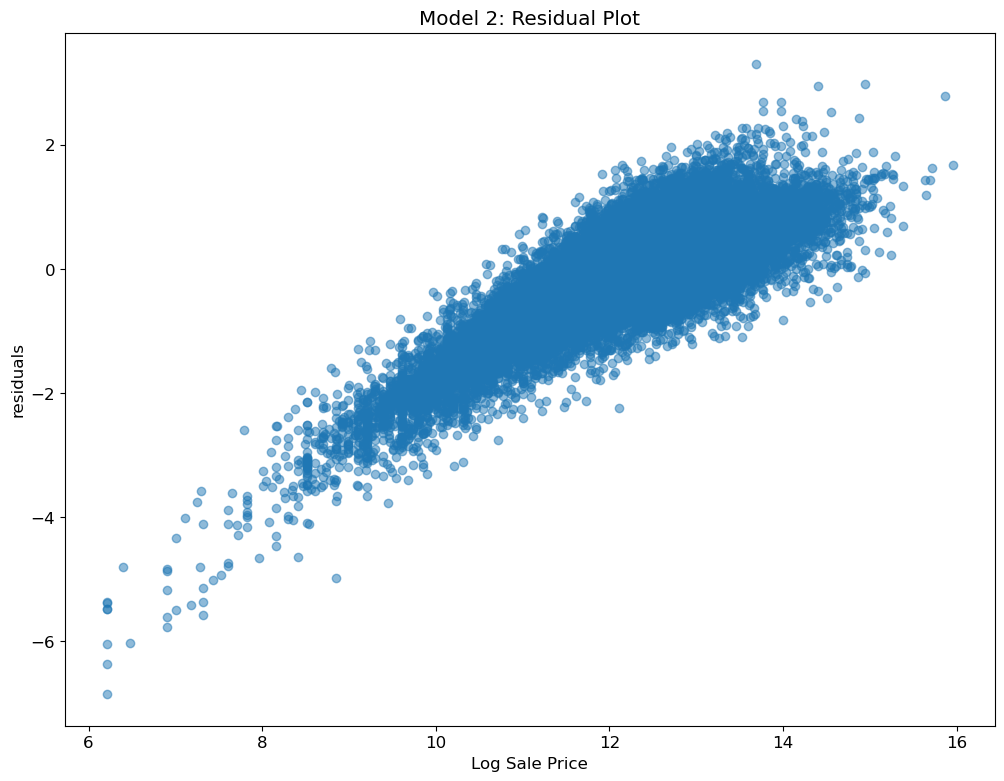

In [22]:
e = y_valid_m2 - y_predicted_m2
plt.scatter(y_valid_m2, e, alpha = .5)
plt.xlabel('Log Sale Price')
plt.ylabel('residuals')
plt.title('Model 2: Residual Plot');

<!-- END QUESTION -->

<br><br>

--- 

## Question 3b

Based on the structure you see in your plot, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?


In [23]:
q3b = 'regressive'

In [24]:
grader.check("q3b")

q3b results: All test cases passed!

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incoporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part (also last part, wohoo!) of this project.

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 4

It is time to build your own model!

To evaluate your model, we will start by defining a linear regression model. Then, we will process training data using your `process_data_final` function (you will define this in 4e), fit the model with this training data, and compute the training RMSE. Then, we will process test data with your `process_data_final`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

Your goal in Question 4 is to:

* Define a function to perform feature engineering and produce a design matrix for modeling
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that our test set does not contain the true `Sale Price` of each house – your model is trying to guess them! 
* Submit your predicted `Log Sale Price`s on the test set to Gradescope


In Question 4a, we will outline some important DataHub logistics.

In Question 4b, you will explore possible features for your model.

In Question 4c, you will perform EDA on the dataset.

In Question 4d, you will define feature engineering helper functions.

And, lastly, in Question 4e, you will create your design matrix and train a model.



### Grading Scheme

Your grade for Question 4 will be based on your model’s RMSE when making predictions on the training set, as well as your model’s RMSE when making predictions on the test set. The tables below provide scoring guidelines. If your RMSE lies in a particular range, you will receive the number of points associated with that range. '

**Important**: while your training RMSE can be checked at any time in this notebook, your test RMSE can only be checked by submitting your model’s predictions to Gradescope. You may only submit to Gradescope 3 times a day. Plan ahead to make sure you have enough time to finetune your model!. The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 200k | [200k, 240k) | [240k, 280k) | More than 280k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 240k | [240k, 280k) | [280k, 300k) | More than 300k

<br><br>

---
## Question 4a Couple notes

- **If you are running into memory issues, restart kernel and only run the cells you need to.** The cell below (question cell) contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed (almost) independently code-wise from the remainder of the project. The autograder will have more than 4 GB memory, so you will not lose credit as long as your solution to Question 4 is within the total memory (4GB) limits of DataHub. Alternatively, you can delete variables you are not using through `del` or `%reset -f`. For example, this will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier. Note: If you need these data again after deleting the variables or reseting, you must reload them again. In addition, you must comment them out before submitting.
- You will be predicting `Log Sale price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e. if the value is 100, it is too large - $e^{100}$ is too big!)
- You **MUST remove any additional new cells you add before submitting to Gradescope** to avoid any autograder errors. 
- You can only submit the csv file to gradescope up to **3 times** per day. Start early!

**Please read the above message carefully. No response is required for this question.**

In [25]:
#Uncomment the line below to clean up memory from previous questions and reinitialize Otter!
# MAKE SURE TO COMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!
# %reset -f
# del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m2
# import otter
# grader = otter.Notebook("projA2.ipynb")

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br><br>

---

## Question 4b Finding Potential Features

**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering in Q4e. You may write as little or as much as you would like here; it will not factor into your grade. Read the documentation about the dataset in `codebook.txt`, located in this directory. Is there any data you think that may be related to housing price? Drop them down below for your later reference.

Land square feet
Central AC 
Age 
Garage Indicator 
practically any "amenities" that the house has

<br><br>

---

## Question 4c More EDA


**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering in Q4e. You may write as little or as much as you would like here; it will not factor into your grade. Use the scratch space below to conduct any additional EDA you would like to see. You may use this space to make additional plots to help you visualize the relationship between any variables or compute any relevant statistics. You are free to add any number of cells as needed below and before the next question. You may find it helpful to review Project A1 and techniques we explore there.


<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas. </summary>
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers?

* Make a scatter plot between a continous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

<br><br>

---

## Question 4d Defining Helper Function or Helper Variables

**This question is not graded but we suggest that you put all your helper functions below for readability and ease of testing.** Use this space below to define any additional helper functions you may use in your final model. These can be transformation functions you identified in the optional question above. 

In [26]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed

    Output:
      a data frame with outliers removed

    Note: This function should not change mutate the contents of data.
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper), :]

def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r'(\d+) of which are bedrooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(int)
    with_rooms['Bedrooms'] = rooms
    return with_rooms

def ohe(data, label):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[[label]])
    dummies = pd.DataFrame(oh_enc.transform(data[[label]]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)


def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def add_total_rooms(data): 
    with_rooms = data.copy()
    with_bathrooms['Bathroom'] = with_bathrooms['Description'].str.extract(r'has a total of ([/d])').astype(int) 
    return with_rooms 

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))








<br><br>

---

## Question 4e Defining Pipeline Funtion

Just as in the guided model from the previous question, you should encapsulate as much of your workflow into functions as possible. Your job is to select better features and define your own feature engineering pipeline inside the function `process_data_final` in the following cell. Use of `.pipe` is not required, but you are welcome to incorporate it! **You must not change the parameters inside `process_data_final`. Do not edit the two lines at the end of the question cell below. They are helper function that defined a linear model, fit your data, and compute RMSE. If you do, you will receive no credit for this question.** 

- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`
- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `y` (the `Log Sale Price` column).


Hinst:
-  Some features may have missing values in the test set but not in the training/validation set. Make sure `process_data_final` handles missing values appropriately for each feature
- We have imported all feature engineering functions from Project A1 for you. You can view them in `feature_func.py`, which can be accesssed through the directory available on the left in File Browser.
- You may wish to consider removing outlying datapoints from the training set before fitting your model. You may not, however, remove any datapoints from the test set (the CCAO could not simply "refuse" to make a prediction for a particular house!)
- As you finetune your model, you may unintentionally consume too much DataHub memory, causing your kernel to crash. See Question 4a for guidance on how to resolve this.
!

In [27]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.

def process_data_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    
    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!
        data = remove_outliers(data, variable = 'Sale Price', lower = np.percentile(data['Sale Price'], 13), upper = np.percentile(data['Sale Price'], 99))

        #Transformations + get property classes 
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        data['Root Garage Area 1'] = np.sqrt(data['Garage 1 Area'])
        data['Root Garage Area 2'] = np.sqrt(data['Garage 2 Area'])
        data = pd.get_dummies(data, columns=['Property Class'], drop_first=True)
        data = data[['Log Sale Price', 'Log Building Square Feet', 'Root Garage Area 1', 'Root Garage Area 2', 'Property Class_203', 'Property Class_204', 'Property Class_205', 'Property Class_206', 'Property Class_207', 'Property Class_208', 'Property Class_209', 'Property Class_278']]
        

    else:
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        data['Root Garage Area 1'] = np.sqrt(data['Garage 1 Area'])
        data['Root Garage Area 2'] = np.sqrt(data['Garage 2 Area'])
        data = pd.get_dummies(data, columns=['Property Class'], drop_first=True)
        data = data[['Log Building Square Feet', 'Root Garage Area 1', 'Root Garage Area 2', 'Property Class_203', 'Property Class_204', 'Property Class_205', 'Property Class_206', 'Property Class_207', 'Property Class_208', 'Property Class_209', 'Property Class_278']]
            #...
    
    
    # Return predictors and response variable separately
    if is_test_set:
        # Optional processing you wish to do, remove ellipsis before submission
        # Predictors
            X = data
            return X
    else:
        # Optional processing you wish to do, remove ellipsis before submission
        # Predictors. Your X should not include Log Sale Price!
            X = data.drop(['Log Sale Price'], axis = 1)
        # Response variable
            y = data.loc[:, 'Log Sale Price'] 
            return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("You can check your grade for your prediction as per the grading scheme outlined at the start of Q4")

Current training RMSE: 184749.4871687697
You can check your grade for your prediction as per the grading scheme outlined at the start of Q4


In [28]:
grader.check("q4e")

q4e results: All test cases passed!

<br><br>

---

## Question 4f Fit and Evaluate your Model

**This question is not graded.** Use this space below to evalute your models. Some ideas are listed below. 

**Note:** While we have grader function that checks RMSE for you, it is best to define create your own model object and fit on your data. This way, you have access to the model directly to help you evaluate/debug if needed. For this project, you should use a sklearn default `LinearRegression()` model with intercept term for grading purposes. Do not modify any hyperparameter in `LinearRegression()`, and focus on feature selection or hyperpameters of your own feature engineering function.


<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
Train set:

* Check your test RMSE. Is this a reasonable number? You may use our grading scheme as reference. Keep in mind that training error is generally less than testing error. 

Test set:
* Find the original data shape at the begining of the notebook (in the provided assert statement). What should the output shape be?

* Since test and training/validation sets comes from the same population (recall that test and training/validation sets are a random split from a larger data), we expect our test prediction to have a similar range as the training data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?

* We cannot compute test RMSE directly since we do not have the observed values. Perform a holdout-test or cross validation (on training/validation sets) to estimate your test error. Recall that we are treating validation set as unseen data.
    
</details>

In [29]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again

<br><br>

---

## Question 4g Submission

Recall that the test set given to you in this assignment does not contain values for the true `Sale Price` of each house. To determine your model’s RMSE on the test set, you will submit the predictions made by your model to Gradescope. There, we will run checks to see what your test RMSE is by considering (hidden) true values for the `Sale Price`.
Your score on this section will be determined by the grading scheme outlined at the start of Question 4. Remember that you can only submit test predictions to Gradescope 3 times per day. Plan your time to ensure that you can adjust your model as necessary.

To determine the error on the test set, please submit your predictions on the contest test set to the Gradescope assignment: **Project A2 Test Set Predictions**. The CSV file to submit is generated below and you should not modify the cell below. Simply download the CSV file and submit it to the appropriate Gradescope assignment.

Note that **you will not receive credit for the test set predictions (i.e. up to 3 points) unless you submit to this assignment**!

In [30]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_final, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

#print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

You may now upload this CSV file to Gradescope for scoring.


In [32]:
# Scratch space to check if your prediction is reasonable. See 4f for hints. 
# We will not reset submission count for mis-submission issues.
submission_df["Value"].describe()

count    55311.000000
mean        12.149369
std          0.575633
min         10.342181
25%         11.746497
50%         12.014838
75%         12.488361
max         14.714225
Name: Value, dtype: float64

_Type your answer here, replacing this text._

Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study - especially because statistical modeling is how the CCAO valuates properties. 

Refer to Lecture 14 if you're having trouble getting started!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## (Optional) Question 5 Evaluating Model in Context

<br><br>

---

## (Optional) Question 5a

When evaluating your model, we used root mean squared error. In the context of estimating the value of houses, what does residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

_Type your answer here, replacing this text._

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<br><br>

---

## (Optional) Question 5b

In your own words, describe how you would define fairness in property assessments and taxes.

_Type your answer here, replacing this text._

## The CCAO and Transparency

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.

<br><br>

---

## (Optional) Question 5c

Take a look at the Residential Automated Valuation Model files under the Models subgroup in the CCAO’s [GitLab](https://gitlab.com/ccao-data-science---modeling). Without directly looking at any code, do you feel that the documentation sufficiently explains how the residential valuation model works? Which part(s) of the documentation might be difficult for nontechnical audiences to understand?


_Type your answer here, replacing this text._

You might feel that the model's inner workings are beyond your pay grade - it's far more complex than the model you built in this assignment, after all! Though we won't delve further into the role of transparency in the broader CCAO case study, consider its effectiveness and/or ineffectiveness: Is the system truly transparent if it's inaccessible to Cook County constituents? Do transparency measures actually bolster the accuracy of a model - or do they only affect the _perceived_ accuracy of a model? 

And if you're interested in thinking more about transparency measures, take Data 104! But for now...

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Project A2!

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Project A2) and the written portion (the PDF with from Project A2) to their respective Gradescope portals, and checking that they are the most recent copy or the copy you wish to submit (including plots).** The coding proportion should be submitted to Project A2 Coding as a single zip file, and the written portion should be submitted to Project A2 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

In [33]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("projA2.ipynb", filtering=True, pagebreaks=True)
if(path.exists('projA2.pdf')):
    display(HTML("Download your PDF <a href='projA2.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [35]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

In [36]:
# Initialize Otter
import otter
grader = otter.Notebook("projA2.ipynb")

**Collaborators:** *list names here*



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

## Introduction

In project A1, you performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this project, you will specify and fit a linear model to a few features of the housing data to predict house prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`.
- Using `scikit-learn` to build and fit linear models.

## Score Breakdown

Question | Manual | Points
----|----|----
00 | No| 2
0a | Yes | 1
0b | Yes | 1
0c | No | 1
0d | Yes | 1
0e | Yes | 1
1 | No | 2
2a | Yes | 2
2b | No | 3
2c | No | 2
3a | Yes | 2
3b | No | 1
4a | No | 0
4b | No | 0
4c | No | 0
4d | No | 0
4e | No | 3
Test Prediction | No | 3
4f | No | 0
4g | No | 0
4h | No | 0
5a | No | 0
5b | No | 0
5c | No | 0
Total | 6 | 26


In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training/validation and test data.

In [3]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`.  In this project, you will train a model on the training/validation set, then use this trained model to predict the `Sale Price`s of the test set. In the cell below, we load the training/validation set into the DataFrame `training_val_data` and the test set into the DataFrame `test_data`.

In [4]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [5]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook. 

In [6]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 0: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset. **You should watch Lecture 14 before attempting this part.**

<br><br>

--- 

### Question 0a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price to be high or low.**


Owner of the house, assessor's office, data scientists trying to investigate the assessment office's accuracy of pricing. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.



Scenairo A and C are unfair. By overvaluing a house, the home owner is forced to pay higher property taxes which sometimes can be unaffordable. This means that people will have their house forclosed on them or have to sell it and move to a less expensive house. As assesment process that systematically overvalues inexpensive properties and undervalues expensive properties designs the property tax system. Thus the homeowners will be taxed by this system which is unfair to a reason synonymous to the one about scenario A. This also can cause issues with appeals on housing assesments. Marginalized communities were found to have less success in appealing the assesed price of their home, thus the wealthier, white people were able to achieve less property tax while minorities suffered from unfair assesments and not being successful in appeals. 

<!-- END QUESTION -->

<br><br>

--- 

### Question 0c

Consider a model that is fit to $n = 30$ training observations. Call the response $y$ (Log Sale Price), the predictions $\hat{y}$, and the residuals $y - \hat{y}$. Which of the following residual plots of $y$ versus $y - \hat{y}$ correspond to a model that might make property assessments that result in to regressive taxation? Recall from Lecture 14 that regressive taxation overvalues inexpensive properties and undervalues expensive properties. Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q0c` to the string letter corresponding to your choice of plot.

Hint: When a model overvalues a property (predicts a `Sale Price` greater than the true `Sale Price`) , what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

![](res-plots.png)


In [7]:
q0c = 'A'

In [8]:
grader.check("q0c")

q0c results: All test cases passed!

## The CCAO Dataset

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

And make sure to watch Lecture 14 before answering the following questions!

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to watch the lecture to answer this question)

Houses were being assesed inacuratley, thus causing working class to lower class minorities to be paying more in property taxes than wealthier white people, who somehow were paying less. Essentially, Cook County failed to accurately asses home prices thus negatively affecting the working class minorities of Chicago. A regressive tax system was developed thus placing burdens on nonwhite homeowners. Appeals of assesments are simply more accessible to the wealthier people, thus they were able to even lower there already low property taxes while the middle to lower class were paying more on property taxes than they should in addition to not being able to get an appeal. These issues stemmed from the assesor's office itself, not an algorithm, and was a result of generational racist practices in real estate in Chicago. An example of this would be redlining, where red colors were used to show "high crime" areas on a map. This turned into a mild form of segregation in Chicago, which is the root of the problem. The assesor's office would racially profile the neighbors of a selected house and make deductions because of this, resulting in minorities being isolated to impoverished areas. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0e

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

The appeals process was practically unavliavble to non-white property owners, thus making it impossible to save their house. 

<!-- END QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 1: Preparing Data


Let's split the dataset into a training set and validation set. We will use the training set to fit our model's parameters, and we will use the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller DataFrames named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20% of the data. You should not be importing any additional libraries for this question. Your answer should use the variable `shuffled_indices` defined for you. Take a look at the`np.permutation` [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html). You should only be using numpy functions to generate randomness!

**Note**: 

You may see that some sources uses the name holdout, validation, or test synonymously since all of them are not used for training directly. There is no difference between holdout and validation set, both can be used for hyperparameter tuning. However, test set should only be used for final unbiased evaluation.

**Hint:**

While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any variable names of your choice) that contain a *random* 80% of the indices in `full_data`, and the remaining 20% of the indices, respectively. Then, use these arrays to index into `data` to create your final `train` and `validation` DataFrames. To ensure that your code matches to our solution, use the first 80% as the the training set and the last 20% as the validation set. 

*The provided tests check that you not only answered correctly, but ended up with the exact same train/validation split as our reference implementation. Later testing is easier this way.*

In [9]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a dataframe `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data respectively. 
    """
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)

    train_num = int(.8* data_len) 
    train_indices = shuffled_indices[:train_num]
    val_indices = shuffled_indices[train_num:]
    train = data.iloc[train_indices]
    validation = data.iloc[val_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

In [10]:
grader.check("q1")

q1 results: All test cases passed!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Simple Model

Now, let's fit our updated linear regression model using the ordinary least squares estimator! We will start you off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br><br>

--- 

## Question 2a

**Without running any calculation or code**, assign `q2a` to be the comparator ('>=', '=', '<=') that fills the blank in the following statement:

Suppose we quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$


In [11]:
q2a = '>='

In [12]:
grader.check("q2a")

q2a results: All test cases passed!

<br><br>

### Pipeline function

In A1, you wrote a few functions that added features to the dataset. Instead of calling them manually one-by-one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, we combined some functions into a single helper function that outputs X and y for the first model above. Try to understand what this function does! 

**Note:** We have automatically imported staff implementations of the functions you wrote in Project A1. These functions are `remove_outliers`, `add_total_bedrooms`, `find_expensive_neighborhoods`, `add_in_expensive_neighborhood`, and `ohe_roof_material`. You are welcome to copy over your own implementations if you like.

In [13]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedrooms column
    data = add_total_bedrooms(data)
    # Select X and y from the full data
    X = data[['Bedrooms']]
    y = data['Log Sale Price']
    return X, y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `process_data_pipe` takes in a dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [14]:
# Run this cell to define process_data_pipe and select_columns, no futher actions needed.
def process_data_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    y = data.loc[:, prediction_col]
    return X, y

<br><br>

--- 

## Question 2b

It is time to prepare the training and validation data for the two models we proposed above. Use the following 2 cells to reload a fresh dataset from scratch and run them through the following preprocessing steps using `process_data_pipe` for each model:

- Perform a `train_val_split` on the original dataset, which has been loaded as the DataFrame `full_data`. Let 80% of the set be training data and 20% of the set be validation data. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.

Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_valid_m1`, `y_valid_m1`. This is already implemented for you. 
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_valid_m2`, `y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

For an example of how to work with pipelines, we have done the processing for m1 for you using `m1_pipelines` by passing in the corresponding pipeline functions as a list of tuples in the below cell. Your task is to do the same for model 2 in the cell after - that is, save your pipelines functions as a list of tuples and assign it to `m2_pipelines` for model 2.

As a refresher, the equations model 1 and model 2 respectively can be found below:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**Note**: 
* Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset exactly the same way for both models (otherwise their performance isn't directly comparable).

In [15]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, y_train_m1 = process_data_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, y_valid_m1 = process_data_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [16]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}), (log_transform, None, {'col': 'Building Square Feet'}), 
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)]

X_train_m2, y_train_m2 = process_data_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, y_valid_m2 = process_data_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(y_train_m2.head())

,Bedrooms,Log Building Square Feet
130829,4,7.870166
193890,2,7.002156
30507,2,6.851185
91308,2,7.228388
131132,3,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [17]:
grader.check("q2b")

q2b results: All test cases passed!

<br><br>

--- 

## Question 2c

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [18]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- 1st Model: predicted values on **training set**: `y_fitted_m1`, predicted values on **validation set**: `y_predicted_m1`
- 2nd Model: predicted values on **training set**: `y_fitted_m2`, predicted values on **validation set**: `y_predicted_m2`

**Note**: To make sure you understand how to find the predicted value for both the training and validation data set, there won't be any hidden tests for this part.

In [19]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [20]:
grader.check("q2c")

q2c results: All test cases passed!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Evaluate Our Simple Model

<br><br>

--- 

## Question 3a


We are moving into analysis of our two models! Let's compare the performance of our two regression models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in valid set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

The function is provided below.

In [21]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br><br>

--- 

## Question 3a

One way of understanding the performance (and appropriateness) of a model is through a plot of the residuals versus the observations.

In the cell below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **validation data**. With a data size this large, it is difficult to avoid overplotting entirely. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting as much as possible.

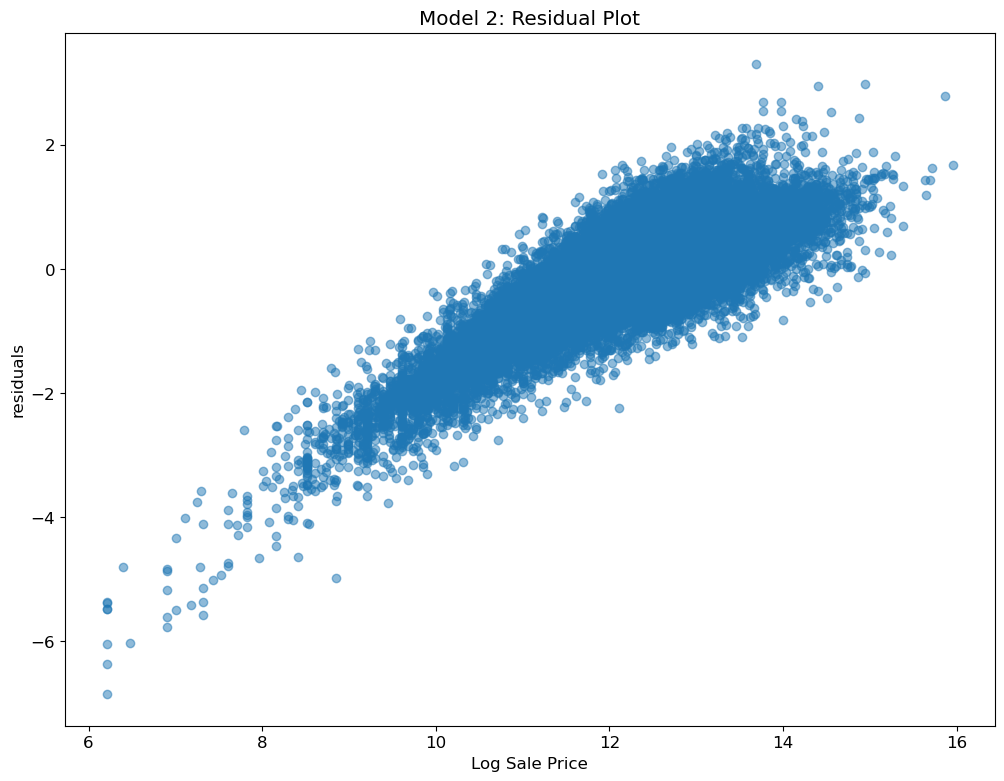

In [22]:
e = y_valid_m2 - y_predicted_m2
plt.scatter(y_valid_m2, e, alpha = .5)
plt.xlabel('Log Sale Price')
plt.ylabel('residuals')
plt.title('Model 2: Residual Plot');

<!-- END QUESTION -->

<br><br>

--- 

## Question 3b

Based on the structure you see in your plot, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?


In [23]:
q3b = 'regressive'

In [24]:
grader.check("q3b")

q3b results: All test cases passed!

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incoporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part (also last part, wohoo!) of this project.

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 4

It is time to build your own model!

To evaluate your model, we will start by defining a linear regression model. Then, we will process training data using your `process_data_final` function (you will define this in 4e), fit the model with this training data, and compute the training RMSE. Then, we will process test data with your `process_data_final`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

Your goal in Question 4 is to:

* Define a function to perform feature engineering and produce a design matrix for modeling
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that our test set does not contain the true `Sale Price` of each house – your model is trying to guess them! 
* Submit your predicted `Log Sale Price`s on the test set to Gradescope


In Question 4a, we will outline some important DataHub logistics.

In Question 4b, you will explore possible features for your model.

In Question 4c, you will perform EDA on the dataset.

In Question 4d, you will define feature engineering helper functions.

And, lastly, in Question 4e, you will create your design matrix and train a model.



### Grading Scheme

Your grade for Question 4 will be based on your model’s RMSE when making predictions on the training set, as well as your model’s RMSE when making predictions on the test set. The tables below provide scoring guidelines. If your RMSE lies in a particular range, you will receive the number of points associated with that range. '

**Important**: while your training RMSE can be checked at any time in this notebook, your test RMSE can only be checked by submitting your model’s predictions to Gradescope. You may only submit to Gradescope 3 times a day. Plan ahead to make sure you have enough time to finetune your model!. The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 200k | [200k, 240k) | [240k, 280k) | More than 280k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 240k | [240k, 280k) | [280k, 300k) | More than 300k

<br><br>

---
## Question 4a Couple notes

- **If you are running into memory issues, restart kernel and only run the cells you need to.** The cell below (question cell) contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed (almost) independently code-wise from the remainder of the project. The autograder will have more than 4 GB memory, so you will not lose credit as long as your solution to Question 4 is within the total memory (4GB) limits of DataHub. Alternatively, you can delete variables you are not using through `del` or `%reset -f`. For example, this will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier. Note: If you need these data again after deleting the variables or reseting, you must reload them again. In addition, you must comment them out before submitting.
- You will be predicting `Log Sale price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e. if the value is 100, it is too large - $e^{100}$ is too big!)
- You **MUST remove any additional new cells you add before submitting to Gradescope** to avoid any autograder errors. 
- You can only submit the csv file to gradescope up to **3 times** per day. Start early!

**Please read the above message carefully. No response is required for this question.**

In [25]:
#Uncomment the line below to clean up memory from previous questions and reinitialize Otter!
# MAKE SURE TO COMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!
# %reset -f
# del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m2
# import otter
# grader = otter.Notebook("projA2.ipynb")

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br><br>

---

## Question 4b Finding Potential Features

**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering in Q4e. You may write as little or as much as you would like here; it will not factor into your grade. Read the documentation about the dataset in `codebook.txt`, located in this directory. Is there any data you think that may be related to housing price? Drop them down below for your later reference.

Land square feet
Central AC 
Age 
Garage Indicator 

<br><br>

---

## Question 4c More EDA


**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering in Q4e. You may write as little or as much as you would like here; it will not factor into your grade. Use the scratch space below to conduct any additional EDA you would like to see. You may use this space to make additional plots to help you visualize the relationship between any variables or compute any relevant statistics. You are free to add any number of cells as needed below and before the next question. You may find it helpful to review Project A1 and techniques we explore there.


<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas. </summary>
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers?

* Make a scatter plot between a continous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

<br><br>

---

## Question 4d Defining Helper Function or Helper Variables

**This question is not graded but we suggest that you put all your helper functions below for readability and ease of testing.** Use this space below to define any additional helper functions you may use in your final model. These can be transformation functions you identified in the optional question above. 

In [27]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed

    Output:
      a data frame with outliers removed

    Note: This function should not change mutate the contents of data.
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper), :]

def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r'(\d+) of which are bedrooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(int)
    with_rooms['Bedrooms'] = rooms
    return with_rooms

def ohe(data, label):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[[label]])
    dummies = pd.DataFrame(oh_enc.transform(data[[label]]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)


def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def add_total_rooms(data): 
    with_rooms = data.copy()
    with_bathrooms['Bathroom'] = with_bathrooms['Description'].str.extract(r'has a total of ([/d])').astype(int) 
    return with_rooms 

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

def CV_error(model, X, Y):
    kf = KFold(n_splits=10)
    validation_errors = []
    for train, test in kf.split(X):
        split_X_train, split_X_test = X.iloc[train], X.iloc[test]
        split_Y_train, split_Y_test = Y.iloc[train], Y.iloc[test]
        model.fit(split_X_train, split_Y_train);
        error = rmse(split_Y_test, model.predict(split_X_test))
        validation_errors.append(error)
    return np.mean(validation_errors)







<br><br>

---

## Question 4e Defining Pipeline Funtion

Just as in the guided model from the previous question, you should encapsulate as much of your workflow into functions as possible. Your job is to select better features and define your own feature engineering pipeline inside the function `process_data_final` in the following cell. Use of `.pipe` is not required, but you are welcome to incorporate it! **You must not change the parameters inside `process_data_final`. Do not edit the two lines at the end of the question cell below. They are helper function that defined a linear model, fit your data, and compute RMSE. If you do, you will receive no credit for this question.** 

- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`
- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `y` (the `Log Sale Price` column).


Hinst:
-  Some features may have missing values in the test set but not in the training/validation set. Make sure `process_data_final` handles missing values appropriately for each feature
- We have imported all feature engineering functions from Project A1 for you. You can view them in `feature_func.py`, which can be accesssed through the directory available on the left in File Browser.
- You may wish to consider removing outlying datapoints from the training set before fitting your model. You may not, however, remove any datapoints from the test set (the CCAO could not simply "refuse" to make a prediction for a particular house!)
- As you finetune your model, you may unintentionally consume too much DataHub memory, causing your kernel to crash. See Question 4a for guidance on how to resolve this.
!

In [31]:
training_val_data['Property Class']

0         203
1         202
2         202
3         203
4         202
         ... 
204787    202
204788    204
204789    202
204790    203
204791    203
Name: Property Class, Length: 204792, dtype: int64

In [29]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.

def process_data_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
   
    data_copy = data.copy() 
    
    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!

        data['Log Sale Price'] = np.log(data['Sale Price'])
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        data = pd.get_dummies(data, columns=['Property Class'], drop_first=True)
        data = data.loc[:, ['Log Sale Price', 'Log Building Square Feet']]
        
        outlier_params = np.linspace(.70, 1, 50)
        CV_errors = []
        
        for param in outlier_params:
            X = data.loc[:, ['Log Sale Price', 'Log Building Square Feet', 'Property Class_203', 'Property Class_204', 'Property Class_205', 'Property Class_206', 'Property Class_207', 'Property Class_208', 'Property Class_209', 'Property Class_278']]
            Y = data[['Log Sale Price']]
            X = remove_outliers(X, 'Log Sale Price', lower=(np.min(X['Log Sale Price']) * (1 - param)), upper=(np.max(X['Log Sale Price']) * param))
            Y = remove_outliers(Y, 'Log Sale Price', lower=(np.min(Y['Log Sale Price']) * (1 - param)), upper=(np.max(Y['Log Sale Price']) * param))
            CV_errors.append(compute_CV_error(lm.LinearRegression(fit_intercept=True), X, Y))
        
        best_cutoff = outlier_params[CV_errors.index(min(CV_errors))]
        data = remove_outliers(data, 'Log Sale Price', lower=(np.min(data['Log Sale Price']) * (1 - best_cutoff)), upper=(np.max(data['Log Sale Price']) * best_cutoff))
        

    else:
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        data = pd.get_dummies(data, columns=['Property Class'], drop_first=True)
        data = data.loc[:, ['Log Building Square Feet', 'Property Class_203', 'Property Class_204', 'Property Class_205', 'Property Class_206', 'Property Class_207', 'Property Class_208', 'Property Class_209', 'Property Class_278']]
            #...
    
    
    # Return predictors and response variable separately
    if is_test_set:
        # Optional processing you wish to do, remove ellipsis before submission
        # Predictors
            X = data
            return X
    else:
        # Optional processing you wish to do, remove ellipsis before submission
        # Predictors. Your X should not include Log Sale Price!
            X = selected_cols.drop(['Log Sale Price'], axis = 1)
        # Response variable
            y = selected_cols['Log Sale Price'] 
            return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("You can check your grade for your prediction as per the grading scheme outlined at the start of Q4")

KeyError: "['Property Class_203', 'Property Class_204', 'Property Class_205', 'Property Class_206', 'Property Class_207', 'Property Class_208', 'Property Class_209', 'Property Class_278'] not in index"

In [ ]:
grader.check("q4e")

<br><br>

---

## Question 4f Fit and Evaluate your Model

**This question is not graded.** Use this space below to evalute your models. Some ideas are listed below. 

**Note:** While we have grader function that checks RMSE for you, it is best to define create your own model object and fit on your data. This way, you have access to the model directly to help you evaluate/debug if needed. For this project, you should use a sklearn default `LinearRegression()` model with intercept term for grading purposes. Do not modify any hyperparameter in `LinearRegression()`, and focus on feature selection or hyperpameters of your own feature engineering function.


<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
Train set:

* Check your test RMSE. Is this a reasonable number? You may use our grading scheme as reference. Keep in mind that training error is generally less than testing error. 

Test set:
* Find the original data shape at the begining of the notebook (in the provided assert statement). What should the output shape be?

* Since test and training/validation sets comes from the same population (recall that test and training/validation sets are a random split from a larger data), we expect our test prediction to have a similar range as the training data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?

* We cannot compute test RMSE directly since we do not have the observed values. Perform a holdout-test or cross validation (on training/validation sets) to estimate your test error. Recall that we are treating validation set as unseen data.
    
</details>

In [ ]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again

<br><br>

---

## Question 4g Submission

Recall that the test set given to you in this assignment does not contain values for the true `Sale Price` of each house. To determine your model’s RMSE on the test set, you will submit the predictions made by your model to Gradescope. There, we will run checks to see what your test RMSE is by considering (hidden) true values for the `Sale Price`.
Your score on this section will be determined by the grading scheme outlined at the start of Question 4. Remember that you can only submit test predictions to Gradescope 3 times per day. Plan your time to ensure that you can adjust your model as necessary.

To determine the error on the test set, please submit your predictions on the contest test set to the Gradescope assignment: **Project A2 Test Set Predictions**. The CSV file to submit is generated below and you should not modify the cell below. Simply download the CSV file and submit it to the appropriate Gradescope assignment.

Note that **you will not receive credit for the test set predictions (i.e. up to 3 points) unless you submit to this assignment**!

In [ ]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_final, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

#print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

In [ ]:
# Scratch space to check if your prediction is reasonable. See 4f for hints. 
# We will not reset submission count for mis-submission issues.
submission_df["Value"].describe()

_Type your answer here, replacing this text._

Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study - especially because statistical modeling is how the CCAO valuates properties. 

Refer to Lecture 14 if you're having trouble getting started!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## (Optional) Question 5 Evaluating Model in Context

<br><br>

---

## (Optional) Question 5a

When evaluating your model, we used root mean squared error. In the context of estimating the value of houses, what does residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

_Type your answer here, replacing this text._

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<br><br>

---

## (Optional) Question 5b

In your own words, describe how you would define fairness in property assessments and taxes.

_Type your answer here, replacing this text._

## The CCAO and Transparency

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.

<br><br>

---

## (Optional) Question 5c

Take a look at the Residential Automated Valuation Model files under the Models subgroup in the CCAO’s [GitLab](https://gitlab.com/ccao-data-science---modeling). Without directly looking at any code, do you feel that the documentation sufficiently explains how the residential valuation model works? Which part(s) of the documentation might be difficult for nontechnical audiences to understand?


_Type your answer here, replacing this text._

You might feel that the model's inner workings are beyond your pay grade - it's far more complex than the model you built in this assignment, after all! Though we won't delve further into the role of transparency in the broader CCAO case study, consider its effectiveness and/or ineffectiveness: Is the system truly transparent if it's inaccessible to Cook County constituents? Do transparency measures actually bolster the accuracy of a model - or do they only affect the _perceived_ accuracy of a model? 

And if you're interested in thinking more about transparency measures, take Data 104! But for now...

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Project A2!

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Project A2) and the written portion (the PDF with from Project A2) to their respective Gradescope portals, and checking that they are the most recent copy or the copy you wish to submit (including plots).** The coding proportion should be submitted to Project A2 Coding as a single zip file, and the written portion should be submitted to Project A2 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

In [ ]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("projA2.ipynb", filtering=True, pagebreaks=True)
if(path.exists('projA2.pdf')):
    display(HTML("Download your PDF <a href='projA2.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()